In [90]:
# ================== Imports ==================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [91]:
# ================== Load Data ==================
jj_sales = pd.read_csv("jj.csv")
print(jj_sales.info())
jj_sales['date'] = pd.to_datetime(jj_sales['date'])
jj_sales.set_index('date', inplace=True)



amzn_stock = pd.read_csv("AMZN.csv")
print(amzn_stock.info())
amzn_stock['Date'] = pd.to_datetime(amzn_stock['Date'])
amzn_stock.set_index('Date', inplace=True)


# Resample AMZN to quarterly to match JJ
amzn_quarterly = amzn_stock['Close'].resample('Q').mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB
None


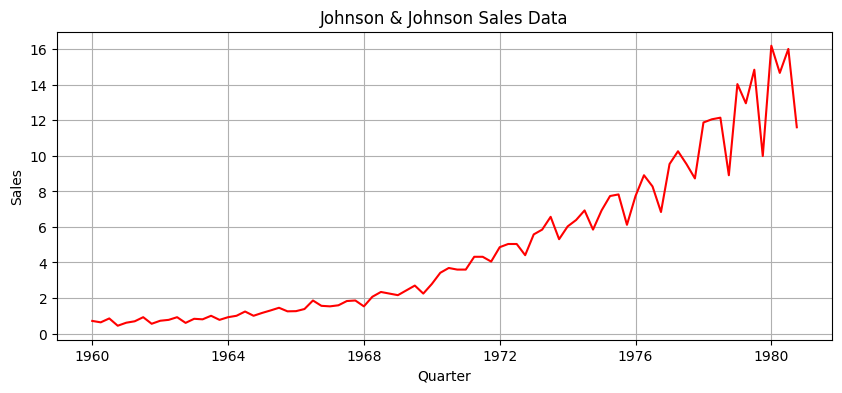

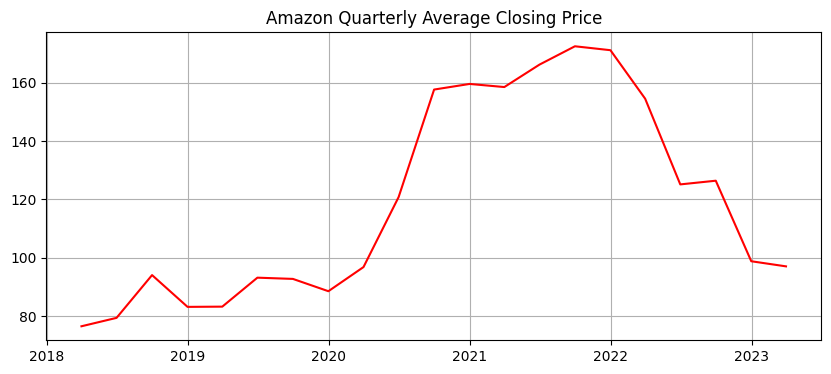

In [92]:
# ================== Initial Plots ==================
plt.figure(figsize=(10, 4))
plt.plot(jj_sales['data'], color = "red")
plt.xlabel('Quarter')
plt.ylabel('Sales')
plt.title('Johnson & Johnson Sales Data')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(amzn_quarterly, color = "red")
plt.title('Amazon Quarterly Average Closing Price')
plt.grid(True)
plt.show()

In [93]:
# ================== ADF Test ==================
adf_jj = adfuller(jj_sales['data'])
print("JJ ADF Statistic:", adf_jj[0])
print("p-value:", adf_jj[1])

adf_amzn = adfuller(amzn_quarterly)
print("AMZN ADF Statistic:", adf_amzn[0])
print("p-value:", adf_amzn[1])

JJ ADF Statistic: 2.7420165734574744
p-value: 1.0
AMZN ADF Statistic: -6.973976458221959
p-value: 8.522105027657795e-10


In [94]:
# ================== First Order Differencing ==================
jj_diff = jj_sales['data'].diff().dropna()
amzn_diff = amzn_quarterly.diff().dropna()

adf_jj_diff = adfuller(jj_diff)
print("First Order Differencing")
print("JJ ADF Statistic:", adf_jj_diff[0])
print("p-value:", adf_jj_diff[1])

First Order Differencing
JJ ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


In [95]:
# ================== Second Order Differencing ==================
jj_diff2 = jj_diff.diff().dropna()
amzn_diff2 = amzn_diff.diff().dropna()

adf_jj_diff2 = adfuller(jj_diff2)
print("Second Order Differencing")
print("JJ ADF Statistic:", adf_jj_diff2[0])
print("p-value:", adf_jj_diff2[1])

Second Order Differencing
JJ ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682


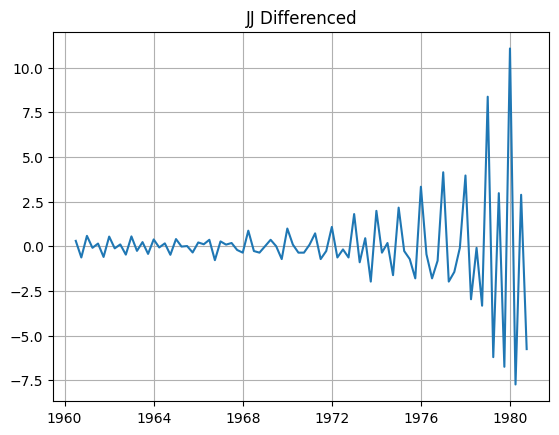

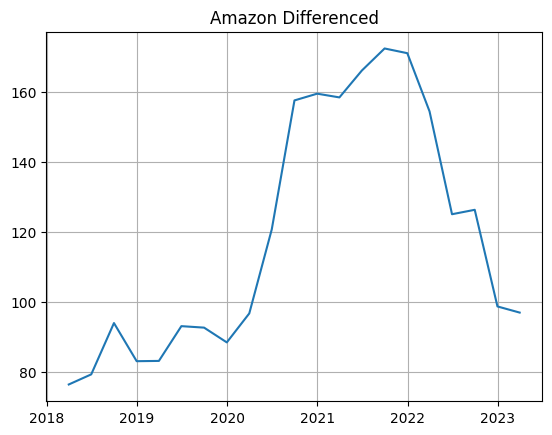

In [96]:
plt.plot(jj_diff2)
plt.title("JJ Differenced")
plt.grid(True)
plt.show()

plt.plot(amzn_quarterly)
plt.title("Amazon Differenced")
plt.grid(True)
plt.show()

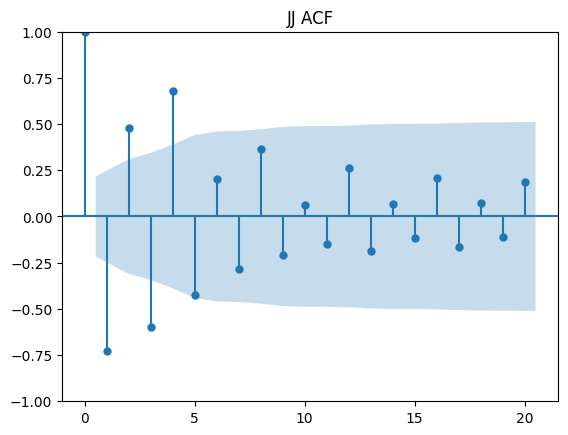

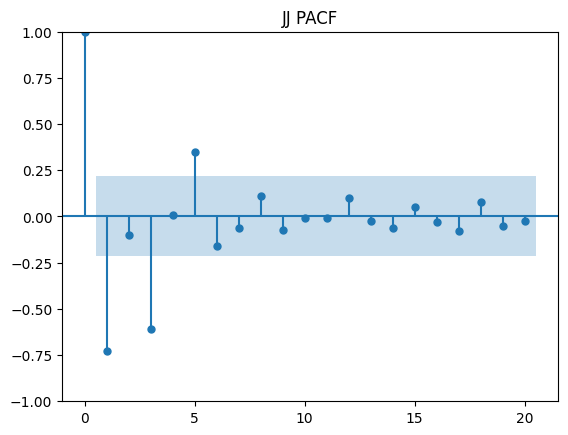

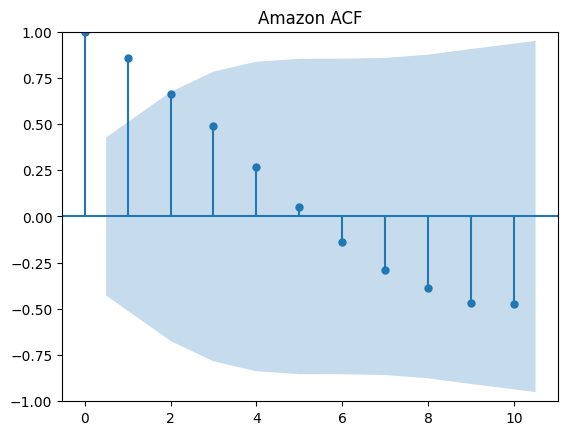

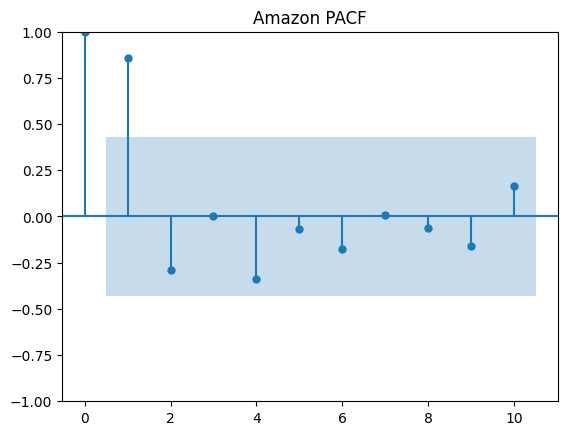

In [97]:
# ================== ACF & PACF ==================
plot_acf(jj_diff2)
plt.title("JJ ACF")
plt.show()

plot_pacf(jj_diff2)
plt.title("JJ PACF")
plt.show()

plot_acf(amzn_quarterly)
plt.title("Amazon ACF")
plt.show()

plot_pacf(amzn_quarterly)
plt.title("Amazon PACF")
plt.show()

In [98]:
def find_best_arma_model(series, max_p=4, max_q=4):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            if p == 0 and q == 0:
                continue
            try:
                model = ARIMA(series, order=(p, 0, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, q)
                    best_model = model
            except:
                continue
    return best_order, best_model


# JJ ARMA on second-order differenced series
jj_order, jj_arma_model = find_best_arma_model(jj_diff2)
print("Best ARMA order for JJ:", jj_order)

# AMZN ARMA on already stationary quarterly data
amzn_order, amzn_arma_model = find_best_arma_model(amzn_quarterly)
print("Best ARMA order for AMZN:", amzn_order)

Best ARMA order for JJ: (3, 3)
Best ARMA order for AMZN: (2, 1)


In [99]:
# ================== Fit ARMA Models ==================
jj_arma_model = ARIMA(jj_diff2, order=(3, 0, 3)).fit()
amzn_arma_model = ARIMA(amzn_quarterly, order=(2, 0, 1)).fit()

# Forecast 24 periods ahead
jj_forecast = jj_arma_model.forecast(steps=24)
amzn_forecast = amzn_arma_model.forecast(steps=24)

# Generate true values for comparison (last 24 actuals)
jj_actual = jj_diff2[-24:]
amzn_actual = amzn_quarterly[-24:]

# Evaluation Metrics
jj_mse = mean_squared_error(jj_actual, jj_forecast[:24])
jj_mape = mean_absolute_percentage_error(jj_actual, jj_forecast[:24])

min_len = min(len(amzn_actual), len(amzn_forecast))
amzn_mse = mean_squared_error(amzn_actual[:min_len], amzn_forecast[:min_len])
amzn_mape = mean_absolute_percentage_error(amzn_actual[:min_len], amzn_forecast[:min_len])

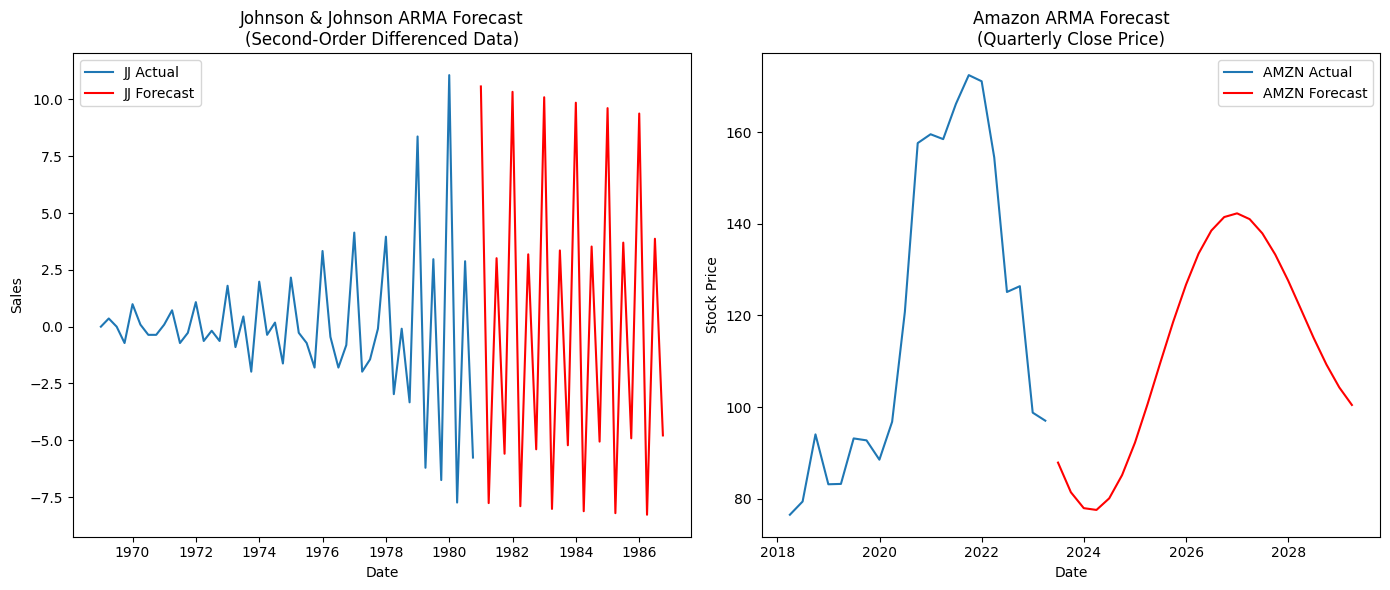

JJ ARMA Model - MSE: 21.6169, MAPE: 735.3850%
AMZN ARMA Model - MSE: 307.7312, MAPE: 11.4946%


In [100]:
# ========== Plot Forecasts ========== #
plt.figure(figsize=(14, 6))

# JJ Forecast Plot
plt.subplot(1, 2, 1)
plt.plot(jj_diff2.index[-48:], jj_diff2[-48:], label='JJ Actual')
forecast_index_jj = pd.date_range(start=jj_diff2.index[-1] + pd.offsets.QuarterEnd(), periods=24, freq='Q')
plt.plot(forecast_index_jj, jj_forecast, label='JJ Forecast', color='red')
plt.title('Johnson & Johnson ARMA Forecast\n(Second-Order Differenced Data)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# AMZN Forecast Plot
plt.subplot(1, 2, 2)
plt.plot(amzn_quarterly.index[-48:], amzn_quarterly[-48:], label='AMZN Actual')
forecast_index_amzn = pd.date_range(start=amzn_quarterly.index[-1] + pd.offsets.QuarterEnd(), periods=24, freq='Q')
plt.plot(forecast_index_amzn, amzn_forecast, label='AMZN Forecast', color='red')
plt.title('Amazon ARMA Forecast\n(Quarterly Close Price)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()

# ========== Print Evaluation Metrics ========== #
print(f"JJ ARMA Model - MSE: {jj_mse:.4f}, MAPE: {jj_mape:.4%}")
print(f"AMZN ARMA Model - MSE: {amzn_mse:.4f}, MAPE: {amzn_mape:.4%}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
JJ LSTM MSE: 1.3388567154366355
JJ LSTM MAPE: 17.123988023980452


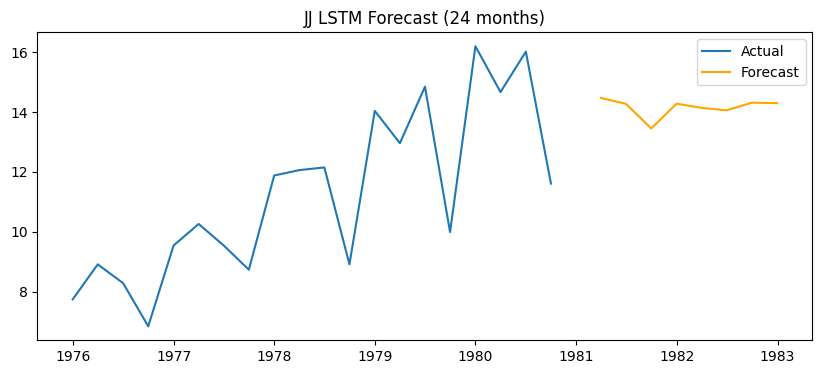

In [101]:
# ================== LSTM for JJ ==================
scaler_jj = MinMaxScaler()
scaled_jj = scaler_jj.fit_transform(jj_sales['data'].values.reshape(-1, 1))

# Prepare data with window size = 3
X_jj, y_jj = [], []
for i in range(3, len(scaled_jj)):
    X_jj.append(scaled_jj[i-3:i])
    y_jj.append(scaled_jj[i])
X_jj, y_jj = np.array(X_jj), np.array(y_jj)

# Reshape for LSTM
X_jj = X_jj.reshape((X_jj.shape[0], X_jj.shape[1], 1))

# Build LSTM model
model_lstm_jj = Sequential()
model_lstm_jj.add(LSTM(50, activation='relu', input_shape=(3,1)))
model_lstm_jj.add(Dense(1))
model_lstm_jj.compile(optimizer='adam', loss='mse')

# Fit model
model_lstm_jj.fit(X_jj, y_jj, epochs=100, verbose=0)

# Predict on training data
pred_lstm_jj = model_lstm_jj.predict(X_jj)

# === Convert predictions back to original scale ===
pred_lstm_jj_inv = scaler_jj.inverse_transform(pred_lstm_jj)
y_jj_inv = scaler_jj.inverse_transform(y_jj.reshape(-1, 1))

# Recalculate metrics on original scale
mse_lstm_jj = mean_squared_error(y_jj_inv, pred_lstm_jj_inv)
mape_lstm_jj = np.mean(np.abs((y_jj_inv - pred_lstm_jj_inv) / (y_jj_inv + 1e-8))) * 100

print("JJ LSTM MSE:", mse_lstm_jj)
print("JJ LSTM MAPE:", mape_lstm_jj)

# === Forecast 8 future quarters ===
forecast_lstm_jj = list(scaled_jj[-3:])
for _ in range(8):
    next_val = model_lstm_jj.predict(np.array([forecast_lstm_jj[-3:]]).reshape(1, 3, 1), verbose=0)
    forecast_lstm_jj.append(next_val[0])
forecast_lstm_jj = scaler_jj.inverse_transform(np.array(forecast_lstm_jj[-8:]))

# === Plot forecast ===
plt.figure(figsize=(10, 4))
plt.plot(jj_sales.index[-20:], jj_sales['data'][-20:], label='Actual')
future_dates = pd.date_range(start=jj_sales.index[-1], periods=9, freq='Q')[1:]
plt.plot(future_dates, forecast_lstm_jj, label='Forecast', color='orange')
plt.title('JJ LSTM Forecast (24 months)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
AMZN LSTM MSE: 0.051834372188627784
AMZN LSTM MAPE: 0.7102572168699203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


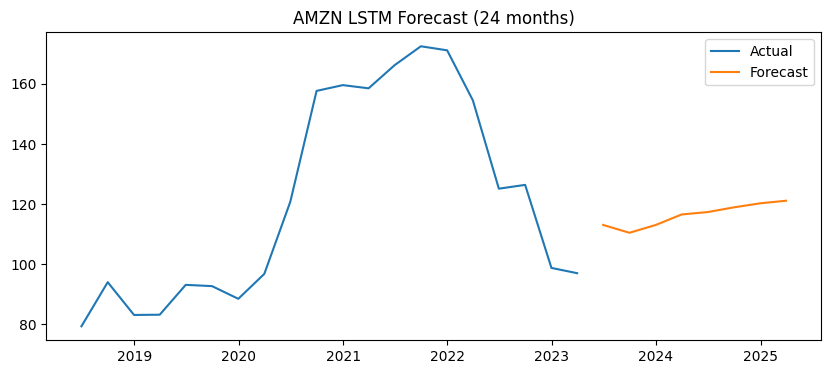

In [102]:
# ================== LSTM for AMZN ==================
scaler_amzn = MinMaxScaler()
scaled_amzn = scaler_amzn.fit_transform(amzn_quarterly.values.reshape(-1, 1))

X_amzn, y_amzn = [], []
for i in range(3, len(scaled_amzn)):
    X_amzn.append(scaled_amzn[i-3:i])
    y_amzn.append(scaled_amzn[i])
X_amzn, y_amzn = np.array(X_amzn), np.array(y_amzn)

model_lstm_amzn = Sequential()
model_lstm_amzn.add(LSTM(50, activation='relu', input_shape=(3,1)))
model_lstm_amzn.add(Dense(1))
model_lstm_amzn.compile(optimizer='adam', loss='mse')
model_lstm_amzn.fit(X_amzn, y_amzn, epochs=100, verbose=0)

pred_lstm_amzn = model_lstm_amzn.predict(X_amzn)
mse_lstm_amzn = mean_squared_error(y_amzn, pred_lstm_amzn)
mape_lstm_amzn = mean_absolute_percentage_error(y_amzn, pred_lstm_amzn)
print("AMZN LSTM MSE:", mse_lstm_amzn)
print("AMZN LSTM MAPE:", mape_lstm_amzn)

forecast_lstm_amzn = list(scaled_amzn[-3:])
for _ in range(8):
    next_val = model_lstm_amzn.predict(np.array([forecast_lstm_amzn[-3:]]))
    forecast_lstm_amzn.append(next_val[0])
forecast_lstm_amzn = scaler_amzn.inverse_transform(np.array(forecast_lstm_amzn[-8:]))

plt.figure(figsize=(10, 4))
plt.plot(amzn_quarterly.index[-20:], amzn_quarterly[-20:], label='Actual')
plt.plot(pd.date_range(start=amzn_quarterly.index[-1], periods=9, freq='Q')[1:], forecast_lstm_amzn, label='Forecast')
plt.title('AMZN LSTM Forecast (24 months)')
plt.legend()
plt.show()